<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:25:21] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


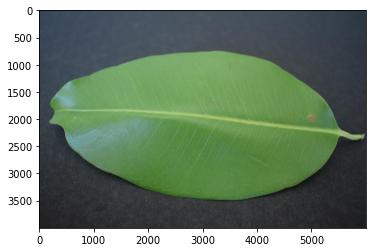

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

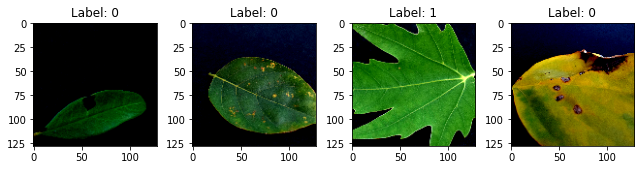

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:25:26] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:25:28] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2161582781676339 samples/sec                   batch loss = 0.4450553357601166 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2680514554552116 samples/sec                   batch loss = 0.6490498185157776 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2653737499532383 samples/sec                   batch loss = 0.9573991894721985 | accuracy = 0.43333333333333335


Epoch[1] Batch[20] Speed: 1.2657212368042885 samples/sec                   batch loss = 0.8247079849243164 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.2656472366630283 samples/sec                   batch loss = 0.560951292514801 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.2691166700114473 samples/sec                   batch loss = 0.6501644253730774 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2620878125577362 samples/sec                   batch loss = 0.6443239450454712 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2632696192424726 samples/sec                   batch loss = 1.262818455696106 | accuracy = 0.51875


Epoch[1] Batch[45] Speed: 1.2637988035910799 samples/sec                   batch loss = 0.5752586126327515 | accuracy = 0.5222222222222223


Epoch[1] Batch[50] Speed: 1.268497659014194 samples/sec                   batch loss = 0.45003214478492737 | accuracy = 0.55


Epoch[1] Batch[55] Speed: 1.2678986065991094 samples/sec                   batch loss = 0.5663092732429504 | accuracy = 0.5636363636363636


Epoch[1] Batch[60] Speed: 1.2682649305335858 samples/sec                   batch loss = 0.3577718138694763 | accuracy = 0.575


Epoch[1] Batch[65] Speed: 1.2700394458862818 samples/sec                   batch loss = 0.7126274704933167 | accuracy = 0.5769230769230769


Epoch[1] Batch[70] Speed: 1.2776961463376963 samples/sec                   batch loss = 0.2773449122905731 | accuracy = 0.5821428571428572


Epoch[1] Batch[75] Speed: 1.2665233803305571 samples/sec                   batch loss = 1.1794383525848389 | accuracy = 0.58


Epoch[1] Batch[80] Speed: 1.273303479860138 samples/sec                   batch loss = 0.555535078048706 | accuracy = 0.584375


Epoch[1] Batch[85] Speed: 1.2747050027025495 samples/sec                   batch loss = 0.965795636177063 | accuracy = 0.5852941176470589


Epoch[1] Batch[90] Speed: 1.263135323967415 samples/sec                   batch loss = 0.5263339877128601 | accuracy = 0.5861111111111111


Epoch[1] Batch[95] Speed: 1.2624952460445662 samples/sec                   batch loss = 1.1594781875610352 | accuracy = 0.5789473684210527


Epoch[1] Batch[100] Speed: 1.2734825736207216 samples/sec                   batch loss = 0.4781706929206848 | accuracy = 0.5875


Epoch[1] Batch[105] Speed: 1.2650701416073098 samples/sec                   batch loss = 0.6867326498031616 | accuracy = 0.5880952380952381


Epoch[1] Batch[110] Speed: 1.2719471746525428 samples/sec                   batch loss = 1.364060401916504 | accuracy = 0.5863636363636363


Epoch[1] Batch[115] Speed: 1.2706617914032963 samples/sec                   batch loss = 0.7278215289115906 | accuracy = 0.5847826086956521


Epoch[1] Batch[120] Speed: 1.2690477438555 samples/sec                   batch loss = 0.6229867339134216 | accuracy = 0.5833333333333334


Epoch[1] Batch[125] Speed: 1.2669081390531771 samples/sec                   batch loss = 0.5116150975227356 | accuracy = 0.586


Epoch[1] Batch[130] Speed: 1.2716577536053653 samples/sec                   batch loss = 0.5353524088859558 | accuracy = 0.5865384615384616


Epoch[1] Batch[135] Speed: 1.2692233379152988 samples/sec                   batch loss = 0.34049883484840393 | accuracy = 0.5907407407407408


Epoch[1] Batch[140] Speed: 1.2724732322922048 samples/sec                   batch loss = 0.6189523935317993 | accuracy = 0.5946428571428571


Epoch[1] Batch[145] Speed: 1.271025958611467 samples/sec                   batch loss = 0.32618457078933716 | accuracy = 0.5982758620689655


Epoch[1] Batch[150] Speed: 1.2704198987735915 samples/sec                   batch loss = 0.7596501708030701 | accuracy = 0.6


Epoch[1] Batch[155] Speed: 1.2656079962281943 samples/sec                   batch loss = 0.5254426002502441 | accuracy = 0.6080645161290322


Epoch[1] Batch[160] Speed: 1.2749996884167956 samples/sec                   batch loss = 1.289513349533081 | accuracy = 0.603125


Epoch[1] Batch[165] Speed: 1.2694240489089312 samples/sec                   batch loss = 0.27818992733955383 | accuracy = 0.6090909090909091


Epoch[1] Batch[170] Speed: 1.2737931350745437 samples/sec                   batch loss = 0.36203625798225403 | accuracy = 0.6132352941176471


Epoch[1] Batch[175] Speed: 1.2733521868291828 samples/sec                   batch loss = 0.5039279460906982 | accuracy = 0.6128571428571429


Epoch[1] Batch[180] Speed: 1.2702123332796798 samples/sec                   batch loss = 0.4629904329776764 | accuracy = 0.6152777777777778


Epoch[1] Batch[185] Speed: 1.2642223941789703 samples/sec                   batch loss = 1.1860092878341675 | accuracy = 0.6135135135135135


Epoch[1] Batch[190] Speed: 1.2680841382682941 samples/sec                   batch loss = 0.4753231704235077 | accuracy = 0.618421052631579


Epoch[1] Batch[195] Speed: 1.2663868629585064 samples/sec                   batch loss = 1.5995601415634155 | accuracy = 0.6192307692307693


Epoch[1] Batch[200] Speed: 1.273430280381039 samples/sec                   batch loss = 0.728641927242279 | accuracy = 0.6225


Epoch[1] Batch[205] Speed: 1.2661654194351966 samples/sec                   batch loss = 0.21851277351379395 | accuracy = 0.624390243902439


Epoch[1] Batch[210] Speed: 1.2683564966504692 samples/sec                   batch loss = 0.5522114634513855 | accuracy = 0.6214285714285714


Epoch[1] Batch[215] Speed: 1.27652741535021 samples/sec                   batch loss = 0.12907300889492035 | accuracy = 0.622093023255814


Epoch[1] Batch[220] Speed: 1.2714430385771176 samples/sec                   batch loss = 0.3176378905773163 | accuracy = 0.6261363636363636


Epoch[1] Batch[225] Speed: 1.2760168282677784 samples/sec                   batch loss = 0.4493149518966675 | accuracy = 0.6322222222222222


Epoch[1] Batch[230] Speed: 1.2734991034308278 samples/sec                   batch loss = 0.2487957775592804 | accuracy = 0.6347826086956522


Epoch[1] Batch[235] Speed: 1.2759226002476522 samples/sec                   batch loss = 0.4611583650112152 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.2751563864887911 samples/sec                   batch loss = 0.16664338111877441 | accuracy = 0.6385416666666667


Epoch[1] Batch[245] Speed: 1.2746847613805197 samples/sec                   batch loss = 0.740304708480835 | accuracy = 0.636734693877551


Epoch[1] Batch[250] Speed: 1.2708304202147378 samples/sec                   batch loss = 0.7495332360267639 | accuracy = 0.638


Epoch[1] Batch[255] Speed: 1.2717288915392269 samples/sec                   batch loss = 0.3565763831138611 | accuracy = 0.6392156862745098


Epoch[1] Batch[260] Speed: 1.2734988134304612 samples/sec                   batch loss = 1.1429380178451538 | accuracy = 0.6394230769230769


Epoch[1] Batch[265] Speed: 1.2797510250004767 samples/sec                   batch loss = 0.5393226742744446 | accuracy = 0.6386792452830189


Epoch[1] Batch[270] Speed: 1.2707212683751186 samples/sec                   batch loss = 0.22047367691993713 | accuracy = 0.6444444444444445


Epoch[1] Batch[275] Speed: 1.2719732116504483 samples/sec                   batch loss = 0.6963415145874023 | accuracy = 0.6445454545454545


Epoch[1] Batch[280] Speed: 1.2739504073141443 samples/sec                   batch loss = 0.7131158113479614 | accuracy = 0.6455357142857143


Epoch[1] Batch[285] Speed: 1.2699187026331797 samples/sec                   batch loss = 0.16776719689369202 | accuracy = 0.6482456140350877


Epoch[1] Batch[290] Speed: 1.2709890799527217 samples/sec                   batch loss = 0.9243038892745972 | accuracy = 0.6491379310344828


Epoch[1] Batch[295] Speed: 1.2767675586953928 samples/sec                   batch loss = 0.6912693381309509 | accuracy = 0.652542372881356


Epoch[1] Batch[300] Speed: 1.2702327213248106 samples/sec                   batch loss = 0.5704992413520813 | accuracy = 0.6516666666666666


Epoch[1] Batch[305] Speed: 1.2675580634905668 samples/sec                   batch loss = 0.6529830694198608 | accuracy = 0.6532786885245901


Epoch[1] Batch[310] Speed: 1.269053695400929 samples/sec                   batch loss = 0.365366667509079 | accuracy = 0.6556451612903226


Epoch[1] Batch[315] Speed: 1.279026132141207 samples/sec                   batch loss = 1.5571739673614502 | accuracy = 0.6531746031746032


Epoch[1] Batch[320] Speed: 1.2718885470931955 samples/sec                   batch loss = 1.1458094120025635 | accuracy = 0.65078125


Epoch[1] Batch[325] Speed: 1.278116545023565 samples/sec                   batch loss = 0.5417338609695435 | accuracy = 0.6515384615384615


Epoch[1] Batch[330] Speed: 1.2755758911125201 samples/sec                   batch loss = 0.6152120232582092 | accuracy = 0.6507575757575758


Epoch[1] Batch[335] Speed: 1.2715453757445137 samples/sec                   batch loss = 0.7511565089225769 | accuracy = 0.6514925373134328


Epoch[1] Batch[340] Speed: 1.27134148859691 samples/sec                   batch loss = 0.45706483721733093 | accuracy = 0.6522058823529412


Epoch[1] Batch[345] Speed: 1.2715520253394614 samples/sec                   batch loss = 0.940237283706665 | accuracy = 0.6528985507246376


Epoch[1] Batch[350] Speed: 1.2728465503358923 samples/sec                   batch loss = 0.344685822725296 | accuracy = 0.6528571428571428


Epoch[1] Batch[355] Speed: 1.273081253287094 samples/sec                   batch loss = 0.31735759973526 | accuracy = 0.6528169014084507


Epoch[1] Batch[360] Speed: 1.267950446501448 samples/sec                   batch loss = 0.5341912508010864 | accuracy = 0.6534722222222222


Epoch[1] Batch[365] Speed: 1.270010796126112 samples/sec                   batch loss = 0.2613712549209595 | accuracy = 0.6534246575342466


Epoch[1] Batch[370] Speed: 1.2675876561807382 samples/sec                   batch loss = 1.3460301160812378 | accuracy = 0.6527027027027027


Epoch[1] Batch[375] Speed: 1.2654729169880217 samples/sec                   batch loss = 0.5205599665641785 | accuracy = 0.654


Epoch[1] Batch[380] Speed: 1.2691583365275587 samples/sec                   batch loss = 0.4459119439125061 | accuracy = 0.6546052631578947


Epoch[1] Batch[385] Speed: 1.2648731889917266 samples/sec                   batch loss = 0.6741104125976562 | accuracy = 0.6558441558441559


Epoch[1] Batch[390] Speed: 1.2664281592265505 samples/sec                   batch loss = 1.0099507570266724 | accuracy = 0.6564102564102564


Epoch[1] Batch[395] Speed: 1.265881679727985 samples/sec                   batch loss = 0.03294893726706505 | accuracy = 0.6594936708860759


Epoch[1] Batch[400] Speed: 1.2686542977804922 samples/sec                   batch loss = 0.9822805523872375 | accuracy = 0.656875


Epoch[1] Batch[405] Speed: 1.2614984019997841 samples/sec                   batch loss = 0.30262431502342224 | accuracy = 0.6580246913580247


Epoch[1] Batch[410] Speed: 1.2652714495327824 samples/sec                   batch loss = 0.4175328314304352 | accuracy = 0.6591463414634147


Epoch[1] Batch[415] Speed: 1.267652784119402 samples/sec                   batch loss = 0.4681478440761566 | accuracy = 0.6602409638554216


Epoch[1] Batch[420] Speed: 1.273419744924641 samples/sec                   batch loss = 0.5884118676185608 | accuracy = 0.6601190476190476


Epoch[1] Batch[425] Speed: 1.2654777850675092 samples/sec                   batch loss = 0.26994043588638306 | accuracy = 0.6629411764705883


Epoch[1] Batch[430] Speed: 1.2680661193829161 samples/sec                   batch loss = 0.4321037232875824 | accuracy = 0.663953488372093


Epoch[1] Batch[435] Speed: 1.2706529377023783 samples/sec                   batch loss = 0.35370922088623047 | accuracy = 0.6649425287356322


Epoch[1] Batch[440] Speed: 1.2675780791071263 samples/sec                   batch loss = 0.25495222210884094 | accuracy = 0.6664772727272728


Epoch[1] Batch[445] Speed: 1.273236030726963 samples/sec                   batch loss = 1.5593842267990112 | accuracy = 0.6679775280898876


Epoch[1] Batch[450] Speed: 1.2725990952579398 samples/sec                   batch loss = 0.10663487017154694 | accuracy = 0.6694444444444444


Epoch[1] Batch[455] Speed: 1.2663079104618542 samples/sec                   batch loss = 1.258634090423584 | accuracy = 0.6686813186813186


Epoch[1] Batch[460] Speed: 1.2697343635176115 samples/sec                   batch loss = 0.3729928731918335 | accuracy = 0.6690217391304348


Epoch[1] Batch[465] Speed: 1.26978481598499 samples/sec                   batch loss = 0.8700369000434875 | accuracy = 0.6682795698924732


Epoch[1] Batch[470] Speed: 1.267274369413163 samples/sec                   batch loss = 0.608018696308136 | accuracy = 0.6675531914893617


Epoch[1] Batch[475] Speed: 1.270295428282498 samples/sec                   batch loss = 0.36355727910995483 | accuracy = 0.6684210526315789


Epoch[1] Batch[480] Speed: 1.2800870176340264 samples/sec                   batch loss = 0.5491194128990173 | accuracy = 0.6682291666666667


Epoch[1] Batch[485] Speed: 1.2684545973269876 samples/sec                   batch loss = 0.7930698394775391 | accuracy = 0.6670103092783505


Epoch[1] Batch[490] Speed: 1.2785243593972044 samples/sec                   batch loss = 2.0531504154205322 | accuracy = 0.6668367346938775


Epoch[1] Batch[495] Speed: 1.26500785407681 samples/sec                   batch loss = 0.4345608353614807 | accuracy = 0.6681818181818182


Epoch[1] Batch[500] Speed: 1.2740686288655567 samples/sec                   batch loss = 0.41887855529785156 | accuracy = 0.6705


Epoch[1] Batch[505] Speed: 1.2669899411643033 samples/sec                   batch loss = 0.9029957056045532 | accuracy = 0.6712871287128713


Epoch[1] Batch[510] Speed: 1.270293312302629 samples/sec                   batch loss = 0.5239706039428711 | accuracy = 0.6715686274509803


Epoch[1] Batch[515] Speed: 1.267310362706551 samples/sec                   batch loss = 0.4713192582130432 | accuracy = 0.6723300970873787


Epoch[1] Batch[520] Speed: 1.2691131179235013 samples/sec                   batch loss = 0.2150532454252243 | accuracy = 0.6716346153846153


Epoch[1] Batch[525] Speed: 1.2690211545682206 samples/sec                   batch loss = 0.37429776787757874 | accuracy = 0.6728571428571428


Epoch[1] Batch[530] Speed: 1.269066270624047 samples/sec                   batch loss = 0.48926684260368347 | accuracy = 0.6735849056603773


Epoch[1] Batch[535] Speed: 1.267583154938116 samples/sec                   batch loss = 0.8774371147155762 | accuracy = 0.6733644859813084


Epoch[1] Batch[540] Speed: 1.2697542557259867 samples/sec                   batch loss = 0.32229945063591003 | accuracy = 0.6726851851851852


Epoch[1] Batch[545] Speed: 1.2740777237398853 samples/sec                   batch loss = 0.40955913066864014 | accuracy = 0.6743119266055045


Epoch[1] Batch[550] Speed: 1.271965400439151 samples/sec                   batch loss = 0.2828262150287628 | accuracy = 0.6763636363636364


Epoch[1] Batch[555] Speed: 1.2744738637467712 samples/sec                   batch loss = 0.9403332471847534 | accuracy = 0.677027027027027


Epoch[1] Batch[560] Speed: 1.2703843058030153 samples/sec                   batch loss = 0.322542667388916 | accuracy = 0.6772321428571428


Epoch[1] Batch[565] Speed: 1.2674735068811132 samples/sec                   batch loss = 0.7515609860420227 | accuracy = 0.6756637168141593


Epoch[1] Batch[570] Speed: 1.267249003027702 samples/sec                   batch loss = 0.6493327021598816 | accuracy = 0.6771929824561403


Epoch[1] Batch[575] Speed: 1.2679430679201988 samples/sec                   batch loss = 0.30373120307922363 | accuracy = 0.6773913043478261


Epoch[1] Batch[580] Speed: 1.2703021609926175 samples/sec                   batch loss = 0.3713933229446411 | accuracy = 0.6780172413793103


Epoch[1] Batch[585] Speed: 1.2750086996925412 samples/sec                   batch loss = 0.6244511604309082 | accuracy = 0.6782051282051282


Epoch[1] Batch[590] Speed: 1.2715355460358986 samples/sec                   batch loss = 0.26122191548347473 | accuracy = 0.6796610169491526


Epoch[1] Batch[595] Speed: 1.271024610528815 samples/sec                   batch loss = 0.18695729970932007 | accuracy = 0.6810924369747899


Epoch[1] Batch[600] Speed: 1.270848517746277 samples/sec                   batch loss = 0.4000977575778961 | accuracy = 0.6829166666666666


Epoch[1] Batch[605] Speed: 1.268085192580637 samples/sec                   batch loss = 0.18205206096172333 | accuracy = 0.6830578512396694


Epoch[1] Batch[610] Speed: 1.2672465143049647 samples/sec                   batch loss = 1.3521639108657837 | accuracy = 0.6836065573770492


Epoch[1] Batch[615] Speed: 1.270938916857636 samples/sec                   batch loss = 0.6883981823921204 | accuracy = 0.6829268292682927


Epoch[1] Batch[620] Speed: 1.268645759827133 samples/sec                   batch loss = 0.38934117555618286 | accuracy = 0.682258064516129


Epoch[1] Batch[625] Speed: 1.2772195295672095 samples/sec                   batch loss = 0.42218154668807983 | accuracy = 0.6828


Epoch[1] Batch[630] Speed: 1.2666100095555084 samples/sec                   batch loss = 0.5359022617340088 | accuracy = 0.682936507936508


Epoch[1] Batch[635] Speed: 1.2738175068272155 samples/sec                   batch loss = 0.6779211759567261 | accuracy = 0.6822834645669291


Epoch[1] Batch[640] Speed: 1.2769261494546817 samples/sec                   batch loss = 0.4219319820404053 | accuracy = 0.682421875


Epoch[1] Batch[645] Speed: 1.2718419767491753 samples/sec                   batch loss = 0.6492351293563843 | accuracy = 0.6825581395348838


Epoch[1] Batch[650] Speed: 1.2687462079708178 samples/sec                   batch loss = 0.11725173890590668 | accuracy = 0.6838461538461539


Epoch[1] Batch[655] Speed: 1.2696245351536626 samples/sec                   batch loss = 0.5622462630271912 | accuracy = 0.684732824427481


Epoch[1] Batch[660] Speed: 1.2684263067185735 samples/sec                   batch loss = 0.4918520152568817 | accuracy = 0.6859848484848485


Epoch[1] Batch[665] Speed: 1.266769147527514 samples/sec                   batch loss = 0.5326921939849854 | accuracy = 0.6857142857142857


Epoch[1] Batch[670] Speed: 1.269938600617892 samples/sec                   batch loss = 0.749106764793396 | accuracy = 0.6854477611940298


Epoch[1] Batch[675] Speed: 1.2685422582755683 samples/sec                   batch loss = 0.6445987224578857 | accuracy = 0.6862962962962963


Epoch[1] Batch[680] Speed: 1.2723175788768728 samples/sec                   batch loss = 0.21215148270130157 | accuracy = 0.6878676470588235


Epoch[1] Batch[685] Speed: 1.2681800878711933 samples/sec                   batch loss = 0.24872133135795593 | accuracy = 0.689051094890511


Epoch[1] Batch[690] Speed: 1.275214152574213 samples/sec                   batch loss = 0.9861907958984375 | accuracy = 0.6880434782608695


Epoch[1] Batch[695] Speed: 1.2717562692334836 samples/sec                   batch loss = 0.6468338966369629 | accuracy = 0.6874100719424461


Epoch[1] Batch[700] Speed: 1.2742776502613538 samples/sec                   batch loss = 0.5262684226036072 | accuracy = 0.6864285714285714


Epoch[1] Batch[705] Speed: 1.275627099849667 samples/sec                   batch loss = 0.43170303106307983 | accuracy = 0.6865248226950355


Epoch[1] Batch[710] Speed: 1.2722973168196419 samples/sec                   batch loss = 0.7485346794128418 | accuracy = 0.6855633802816902


Epoch[1] Batch[715] Speed: 1.2706138674089051 samples/sec                   batch loss = 0.612522304058075 | accuracy = 0.6863636363636364


Epoch[1] Batch[720] Speed: 1.2695828380217948 samples/sec                   batch loss = 0.3910798132419586 | accuracy = 0.6857638888888888


Epoch[1] Batch[725] Speed: 1.260842451658809 samples/sec                   batch loss = 1.1198704242706299 | accuracy = 0.6851724137931035


Epoch[1] Batch[730] Speed: 1.2657383296799634 samples/sec                   batch loss = 0.16887836158275604 | accuracy = 0.6856164383561644


Epoch[1] Batch[735] Speed: 1.2653714594642864 samples/sec                   batch loss = 0.15676699578762054 | accuracy = 0.6850340136054421


Epoch[1] Batch[740] Speed: 1.2678782934125967 samples/sec                   batch loss = 0.46121659874916077 | accuracy = 0.6858108108108109


Epoch[1] Batch[745] Speed: 1.264089896377156 samples/sec                   batch loss = 0.6571254730224609 | accuracy = 0.6869127516778524


Epoch[1] Batch[750] Speed: 1.2690928618019768 samples/sec                   batch loss = 0.4936778247356415 | accuracy = 0.6873333333333334


Epoch[1] Batch[755] Speed: 1.266344135627281 samples/sec                   batch loss = 0.48151156306266785 | accuracy = 0.6880794701986755


Epoch[1] Batch[760] Speed: 1.270271094939598 samples/sec                   batch loss = 0.35811561346054077 | accuracy = 0.6894736842105263


Epoch[1] Batch[765] Speed: 1.2746924123309802 samples/sec                   batch loss = 0.6120465993881226 | accuracy = 0.6901960784313725


Epoch[1] Batch[770] Speed: 1.2684022367199572 samples/sec                   batch loss = 0.3653852939605713 | accuracy = 0.689935064935065


Epoch[1] Batch[775] Speed: 1.2716684527048057 samples/sec                   batch loss = 0.1685428023338318 | accuracy = 0.6912903225806452


Epoch[1] Batch[780] Speed: 1.2659847475590096 samples/sec                   batch loss = 0.45659440755844116 | accuracy = 0.691025641025641


Epoch[1] Batch[785] Speed: 1.271603682532618 samples/sec                   batch loss = 0.6172122359275818 | accuracy = 0.6907643312101911


[Epoch 1] training: accuracy=0.6900380710659898
[Epoch 1] time cost: 648.189435005188
[Epoch 1] validation: validation accuracy=0.6966666666666667


Epoch[2] Batch[5] Speed: 1.2661932270364584 samples/sec                   batch loss = 0.400873601436615 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2743706674746615 samples/sec                   batch loss = 0.6520705223083496 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2662392890494165 samples/sec                   batch loss = 0.3964504897594452 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.2728851786162596 samples/sec                   batch loss = 0.4323849678039551 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2720469889336294 samples/sec                   batch loss = 1.0855656862258911 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2699865698208084 samples/sec                   batch loss = 0.21592871844768524 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2675056811129126 samples/sec                   batch loss = 0.42247089743614197 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2704757933821156 samples/sec                   batch loss = 0.6760402321815491 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.2705738372850344 samples/sec                   batch loss = 0.5729225873947144 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2766050246167704 samples/sec                   batch loss = 0.40737468004226685 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.272249655286737 samples/sec                   batch loss = 0.3823786675930023 | accuracy = 0.7181818181818181


Epoch[2] Batch[60] Speed: 1.2661083746742041 samples/sec                   batch loss = 0.5545790195465088 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.2705018663876653 samples/sec                   batch loss = 1.0569243431091309 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.27272758996199 samples/sec                   batch loss = 0.41975587606430054 | accuracy = 0.725


Epoch[2] Batch[75] Speed: 1.2744838357542163 samples/sec                   batch loss = 0.6412253379821777 | accuracy = 0.7133333333333334


Epoch[2] Batch[80] Speed: 1.273906587713873 samples/sec                   batch loss = 0.559101402759552 | accuracy = 0.7125


Epoch[2] Batch[85] Speed: 1.269904091949652 samples/sec                   batch loss = 0.4027000665664673 | accuracy = 0.7088235294117647


Epoch[2] Batch[90] Speed: 1.2678802097231414 samples/sec                   batch loss = 0.4054413437843323 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2730979658923105 samples/sec                   batch loss = 0.34310874342918396 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.2741984850167214 samples/sec                   batch loss = 0.26183390617370605 | accuracy = 0.72


Epoch[2] Batch[105] Speed: 1.2772438381410232 samples/sec                   batch loss = 0.5635212063789368 | accuracy = 0.7238095238095238


Epoch[2] Batch[110] Speed: 1.268435033517418 samples/sec                   batch loss = 0.3638491928577423 | accuracy = 0.7272727272727273


Epoch[2] Batch[115] Speed: 1.2696662350245527 samples/sec                   batch loss = 1.0894936323165894 | accuracy = 0.7260869565217392


Epoch[2] Batch[120] Speed: 1.2712165485001854 samples/sec                   batch loss = 0.3968299627304077 | accuracy = 0.7229166666666667


Epoch[2] Batch[125] Speed: 1.2748783877270389 samples/sec                   batch loss = 0.45682674646377563 | accuracy = 0.73


Epoch[2] Batch[130] Speed: 1.2718039902156422 samples/sec                   batch loss = 0.3761536478996277 | accuracy = 0.7326923076923076


Epoch[2] Batch[135] Speed: 1.2772567706793674 samples/sec                   batch loss = 0.11557986587285995 | accuracy = 0.7333333333333333


Epoch[2] Batch[140] Speed: 1.2781289110149723 samples/sec                   batch loss = 0.6975262761116028 | accuracy = 0.7285714285714285


Epoch[2] Batch[145] Speed: 1.2718086178953003 samples/sec                   batch loss = 0.47859716415405273 | accuracy = 0.7310344827586207


Epoch[2] Batch[150] Speed: 1.2736877283130068 samples/sec                   batch loss = 0.5074555277824402 | accuracy = 0.7333333333333333


Epoch[2] Batch[155] Speed: 1.2742415504639715 samples/sec                   batch loss = 0.9152219891548157 | accuracy = 0.7370967741935484


Epoch[2] Batch[160] Speed: 1.2748284983759197 samples/sec                   batch loss = 0.2688806653022766 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.2678401600373492 samples/sec                   batch loss = 0.9268182516098022 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.2745928603054486 samples/sec                   batch loss = 0.44671836495399475 | accuracy = 0.7441176470588236


Epoch[2] Batch[175] Speed: 1.2734324068245748 samples/sec                   batch loss = 0.7534351944923401 | accuracy = 0.7371428571428571


Epoch[2] Batch[180] Speed: 1.2750299202966464 samples/sec                   batch loss = 0.42727744579315186 | accuracy = 0.7347222222222223


Epoch[2] Batch[185] Speed: 1.273761027681188 samples/sec                   batch loss = 0.24497132003307343 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2698197026070137 samples/sec                   batch loss = 0.5116181373596191 | accuracy = 0.7407894736842106


Epoch[2] Batch[195] Speed: 1.276531203318132 samples/sec                   batch loss = 0.2169865369796753 | accuracy = 0.7435897435897436


Epoch[2] Batch[200] Speed: 1.2748591096313808 samples/sec                   batch loss = 0.36196503043174744 | accuracy = 0.74375


Epoch[2] Batch[205] Speed: 1.2709359322301477 samples/sec                   batch loss = 0.15923912823200226 | accuracy = 0.7439024390243902


Epoch[2] Batch[210] Speed: 1.2694295237343642 samples/sec                   batch loss = 0.4844309091567993 | accuracy = 0.7452380952380953


Epoch[2] Batch[215] Speed: 1.2729344330742303 samples/sec                   batch loss = 0.45863786339759827 | accuracy = 0.7453488372093023


Epoch[2] Batch[220] Speed: 1.2714083517502157 samples/sec                   batch loss = 0.31933844089508057 | accuracy = 0.7465909090909091


Epoch[2] Batch[225] Speed: 1.270753318954825 samples/sec                   batch loss = 0.47873714566230774 | accuracy = 0.7455555555555555


Epoch[2] Batch[230] Speed: 1.2762095975172616 samples/sec                   batch loss = 0.6722739338874817 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.2726299856801577 samples/sec                   batch loss = 0.25709623098373413 | accuracy = 0.7510638297872341


Epoch[2] Batch[240] Speed: 1.2758230500242127 samples/sec                   batch loss = 0.8918933868408203 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.274808349997367 samples/sec                   batch loss = 0.5036757588386536 | accuracy = 0.746938775510204


Epoch[2] Batch[250] Speed: 1.2701203067115194 samples/sec                   batch loss = 0.22229412198066711 | accuracy = 0.75


Epoch[2] Batch[255] Speed: 1.2762754202955837 samples/sec                   batch loss = 0.4781419336795807 | accuracy = 0.75


Epoch[2] Batch[260] Speed: 1.2764665195671498 samples/sec                   batch loss = 0.5475467443466187 | accuracy = 0.7509615384615385


Epoch[2] Batch[265] Speed: 1.2761885317790966 samples/sec                   batch loss = 0.0565139539539814 | accuracy = 0.7509433962264151


Epoch[2] Batch[270] Speed: 1.2720222026694912 samples/sec                   batch loss = 0.5375902652740479 | accuracy = 0.7537037037037037


Epoch[2] Batch[275] Speed: 1.2767553161939682 samples/sec                   batch loss = 0.6989042162895203 | accuracy = 0.7509090909090909


Epoch[2] Batch[280] Speed: 1.2736082496139827 samples/sec                   batch loss = 0.9084395170211792 | accuracy = 0.7535714285714286


Epoch[2] Batch[285] Speed: 1.2703040846371885 samples/sec                   batch loss = 0.2914084494113922 | accuracy = 0.7543859649122807


Epoch[2] Batch[290] Speed: 1.2688210507385 samples/sec                   batch loss = 0.37003615498542786 | accuracy = 0.756896551724138


Epoch[2] Batch[295] Speed: 1.2748954381869468 samples/sec                   batch loss = 2.5545780658721924 | accuracy = 0.7567796610169492


Epoch[2] Batch[300] Speed: 1.271365188564211 samples/sec                   batch loss = 0.5248184204101562 | accuracy = 0.755


Epoch[2] Batch[305] Speed: 1.2718212477757438 samples/sec                   batch loss = 0.8987818360328674 | accuracy = 0.7565573770491804


Epoch[2] Batch[310] Speed: 1.2717259995981043 samples/sec                   batch loss = 0.2003810703754425 | accuracy = 0.7556451612903226


Epoch[2] Batch[315] Speed: 1.276968038762335 samples/sec                   batch loss = 0.20020215213298798 | accuracy = 0.7555555555555555


Epoch[2] Batch[320] Speed: 1.27570489068406 samples/sec                   batch loss = 0.344890296459198 | accuracy = 0.75546875


Epoch[2] Batch[325] Speed: 1.2759034846234583 samples/sec                   batch loss = 1.084946870803833 | accuracy = 0.7546153846153846


Epoch[2] Batch[330] Speed: 1.278933214048066 samples/sec                   batch loss = 0.3178510367870331 | accuracy = 0.7560606060606061


Epoch[2] Batch[335] Speed: 1.2775924275999664 samples/sec                   batch loss = 0.577332615852356 | accuracy = 0.7582089552238805


Epoch[2] Batch[340] Speed: 1.2739529224378667 samples/sec                   batch loss = 0.7199010252952576 | accuracy = 0.7595588235294117


Epoch[2] Batch[345] Speed: 1.2756901465553463 samples/sec                   batch loss = 0.1009049043059349 | accuracy = 0.7601449275362319


Epoch[2] Batch[350] Speed: 1.2750078276280312 samples/sec                   batch loss = 0.14038453996181488 | accuracy = 0.76


Epoch[2] Batch[355] Speed: 1.2733753819336948 samples/sec                   batch loss = 0.22175703942775726 | accuracy = 0.7598591549295775


Epoch[2] Batch[360] Speed: 1.2683197727350215 samples/sec                   batch loss = 0.6191741228103638 | accuracy = 0.7583333333333333


Epoch[2] Batch[365] Speed: 1.275083701703416 samples/sec                   batch loss = 0.44035011529922485 | accuracy = 0.7582191780821917


Epoch[2] Batch[370] Speed: 1.2736033187806208 samples/sec                   batch loss = 0.1815336048603058 | accuracy = 0.7594594594594595


Epoch[2] Batch[375] Speed: 1.2718144025422315 samples/sec                   batch loss = 0.57513827085495 | accuracy = 0.7566666666666667


Epoch[2] Batch[380] Speed: 1.2751068630221338 samples/sec                   batch loss = 0.35196852684020996 | accuracy = 0.7559210526315789


Epoch[2] Batch[385] Speed: 1.2714170232795075 samples/sec                   batch loss = 1.0724351406097412 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.2788436237618388 samples/sec                   batch loss = 0.6525461673736572 | accuracy = 0.757051282051282


Epoch[2] Batch[395] Speed: 1.269764250114226 samples/sec                   batch loss = 0.4298827648162842 | accuracy = 0.7563291139240507


Epoch[2] Batch[400] Speed: 1.2770084728120656 samples/sec                   batch loss = 0.22959542274475098 | accuracy = 0.758125


Epoch[2] Batch[405] Speed: 1.2694951292633134 samples/sec                   batch loss = 0.3786261975765228 | accuracy = 0.758641975308642


Epoch[2] Batch[410] Speed: 1.2702874453044073 samples/sec                   batch loss = 0.6136764287948608 | accuracy = 0.7597560975609756


Epoch[2] Batch[415] Speed: 1.2683426889758649 samples/sec                   batch loss = 0.270000696182251 | accuracy = 0.7608433734939759


Epoch[2] Batch[420] Speed: 1.2730027195789502 samples/sec                   batch loss = 0.6661326885223389 | accuracy = 0.7607142857142857


Epoch[2] Batch[425] Speed: 1.2696009961135288 samples/sec                   batch loss = 2.695380449295044 | accuracy = 0.76


Epoch[2] Batch[430] Speed: 1.2691124459090997 samples/sec                   batch loss = 0.16976316273212433 | accuracy = 0.7622093023255814


Epoch[2] Batch[435] Speed: 1.268692767962052 samples/sec                   batch loss = 0.2978159785270691 | accuracy = 0.7609195402298851


Epoch[2] Batch[440] Speed: 1.2739284487711877 samples/sec                   batch loss = 1.075348138809204 | accuracy = 0.7607954545454545


Epoch[2] Batch[445] Speed: 1.265445236463693 samples/sec                   batch loss = 0.4553576111793518 | accuracy = 0.7617977528089888


Epoch[2] Batch[450] Speed: 1.269759829500023 samples/sec                   batch loss = 0.21860942244529724 | accuracy = 0.7611111111111111


Epoch[2] Batch[455] Speed: 1.2676275941377229 samples/sec                   batch loss = 0.3049625754356384 | accuracy = 0.7615384615384615


Epoch[2] Batch[460] Speed: 1.2674091633175097 samples/sec                   batch loss = 0.5285577774047852 | accuracy = 0.758695652173913


Epoch[2] Batch[465] Speed: 1.270798654517492 samples/sec                   batch loss = 0.6863280534744263 | accuracy = 0.7602150537634409


Epoch[2] Batch[470] Speed: 1.2728171944107831 samples/sec                   batch loss = 0.46281692385673523 | accuracy = 0.7601063829787233


Epoch[2] Batch[475] Speed: 1.2716393438646787 samples/sec                   batch loss = 0.1499919593334198 | accuracy = 0.7610526315789473


Epoch[2] Batch[480] Speed: 1.2721694877674785 samples/sec                   batch loss = 0.4707430601119995 | accuracy = 0.7609375


Epoch[2] Batch[485] Speed: 1.270274749690499 samples/sec                   batch loss = 0.6380528211593628 | accuracy = 0.7603092783505154


Epoch[2] Batch[490] Speed: 1.2702378184383583 samples/sec                   batch loss = 0.7440041303634644 | accuracy = 0.7596938775510204


Epoch[2] Batch[495] Speed: 1.2769397558889781 samples/sec                   batch loss = 0.7082583904266357 | accuracy = 0.759090909090909


Epoch[2] Batch[500] Speed: 1.2680197326936657 samples/sec                   batch loss = 0.42920368909835815 | accuracy = 0.7605


Epoch[2] Batch[505] Speed: 1.2695611258532273 samples/sec                   batch loss = 0.2093888819217682 | accuracy = 0.7618811881188119


Epoch[2] Batch[510] Speed: 1.263211218213258 samples/sec                   batch loss = 0.598549485206604 | accuracy = 0.7627450980392156


Epoch[2] Batch[515] Speed: 1.2676775919619228 samples/sec                   batch loss = 0.34546977281570435 | accuracy = 0.7611650485436893


Epoch[2] Batch[520] Speed: 1.2717490390940491 samples/sec                   batch loss = 2.09226131439209 | accuracy = 0.760576923076923


Epoch[2] Batch[525] Speed: 1.276285323425038 samples/sec                   batch loss = 0.5427159667015076 | accuracy = 0.7614285714285715


Epoch[2] Batch[530] Speed: 1.264708234729902 samples/sec                   batch loss = 0.2143702208995819 | accuracy = 0.7622641509433963


Epoch[2] Batch[535] Speed: 1.275926190555682 samples/sec                   batch loss = 0.5363326668739319 | accuracy = 0.7607476635514019


Epoch[2] Batch[540] Speed: 1.2720738980726853 samples/sec                   batch loss = 0.47110286355018616 | accuracy = 0.7606481481481482


Epoch[2] Batch[545] Speed: 1.2829500451209948 samples/sec                   batch loss = 0.5872346758842468 | accuracy = 0.7600917431192661


Epoch[2] Batch[550] Speed: 1.2747848120732885 samples/sec                   batch loss = 0.3504793643951416 | accuracy = 0.7604545454545455


Epoch[2] Batch[555] Speed: 1.2690191388193153 samples/sec                   batch loss = 0.7552832961082458 | accuracy = 0.7594594594594595


Epoch[2] Batch[560] Speed: 1.2691222381893232 samples/sec                   batch loss = 0.6494485139846802 | accuracy = 0.759375


Epoch[2] Batch[565] Speed: 1.2655090943953384 samples/sec                   batch loss = 0.25090351700782776 | accuracy = 0.7597345132743363


Epoch[2] Batch[570] Speed: 1.270879612049241 samples/sec                   batch loss = 0.14506496489048004 | accuracy = 0.7600877192982456


Epoch[2] Batch[575] Speed: 1.2693225330712254 samples/sec                   batch loss = 0.6116542220115662 | accuracy = 0.76


Epoch[2] Batch[580] Speed: 1.268141265353915 samples/sec                   batch loss = 0.3199369013309479 | accuracy = 0.7599137931034483


Epoch[2] Batch[585] Speed: 1.2623558912932724 samples/sec                   batch loss = 0.8360622525215149 | accuracy = 0.7589743589743589


Epoch[2] Batch[590] Speed: 1.2717319762909216 samples/sec                   batch loss = 0.4521385431289673 | accuracy = 0.7580508474576271


Epoch[2] Batch[595] Speed: 1.2659594327741714 samples/sec                   batch loss = 0.2224116176366806 | accuracy = 0.7579831932773109


Epoch[2] Batch[600] Speed: 1.2702855217102305 samples/sec                   batch loss = 0.5585033893585205 | accuracy = 0.75875


Epoch[2] Batch[605] Speed: 1.268482889197401 samples/sec                   batch loss = 0.11024094372987747 | accuracy = 0.7586776859504132


Epoch[2] Batch[610] Speed: 1.2694822573656943 samples/sec                   batch loss = 0.36667078733444214 | accuracy = 0.759016393442623


Epoch[2] Batch[615] Speed: 1.2681394441090061 samples/sec                   batch loss = 0.22630998492240906 | accuracy = 0.7597560975609756


Epoch[2] Batch[620] Speed: 1.2701179990065998 samples/sec                   batch loss = 0.5807214379310608 | accuracy = 0.760483870967742


Epoch[2] Batch[625] Speed: 1.2696305881907788 samples/sec                   batch loss = 0.39730599522590637 | accuracy = 0.7608


Epoch[2] Batch[630] Speed: 1.2678346989125946 samples/sec                   batch loss = 0.2785033881664276 | accuracy = 0.7619047619047619


Epoch[2] Batch[635] Speed: 1.2719526712633373 samples/sec                   batch loss = 0.43184882402420044 | accuracy = 0.7633858267716536


Epoch[2] Batch[640] Speed: 1.2667277333770646 samples/sec                   batch loss = 0.9216816425323486 | accuracy = 0.762109375


Epoch[2] Batch[645] Speed: 1.2722707841491525 samples/sec                   batch loss = 0.10932286083698273 | accuracy = 0.762015503875969


Epoch[2] Batch[650] Speed: 1.270118672086335 samples/sec                   batch loss = 0.5802809596061707 | accuracy = 0.7623076923076924


Epoch[2] Batch[655] Speed: 1.2671113721951446 samples/sec                   batch loss = 0.8405900001525879 | accuracy = 0.7625954198473283


Epoch[2] Batch[660] Speed: 1.2703882497906882 samples/sec                   batch loss = 0.31532371044158936 | accuracy = 0.7640151515151515


Epoch[2] Batch[665] Speed: 1.2641200893349256 samples/sec                   batch loss = 0.9633405208587646 | accuracy = 0.7631578947368421


Epoch[2] Batch[670] Speed: 1.2662201757741847 samples/sec                   batch loss = 0.4278157353401184 | accuracy = 0.7626865671641792


Epoch[2] Batch[675] Speed: 1.2650153893018339 samples/sec                   batch loss = 0.30077505111694336 | accuracy = 0.7625925925925926


Epoch[2] Batch[680] Speed: 1.2717365070471047 samples/sec                   batch loss = 0.4619947075843811 | accuracy = 0.763235294117647


Epoch[2] Batch[685] Speed: 1.2676433018415008 samples/sec                   batch loss = 0.6271882653236389 | accuracy = 0.7631386861313869


Epoch[2] Batch[690] Speed: 1.2655371595607812 samples/sec                   batch loss = 0.6392036080360413 | accuracy = 0.7626811594202898


Epoch[2] Batch[695] Speed: 1.269970611727816 samples/sec                   batch loss = 0.4265141785144806 | accuracy = 0.7615107913669065


Epoch[2] Batch[700] Speed: 1.271262206104435 samples/sec                   batch loss = 0.4065903425216675 | accuracy = 0.7610714285714286


Epoch[2] Batch[705] Speed: 1.266442785634012 samples/sec                   batch loss = 0.5941848754882812 | accuracy = 0.7617021276595745


Epoch[2] Batch[710] Speed: 1.2675907208748582 samples/sec                   batch loss = 0.3763183355331421 | accuracy = 0.7623239436619719


Epoch[2] Batch[715] Speed: 1.2654777850675092 samples/sec                   batch loss = 0.4223300814628601 | accuracy = 0.762937062937063


Epoch[2] Batch[720] Speed: 1.2670996969633803 samples/sec                   batch loss = 1.0457026958465576 | accuracy = 0.7631944444444444


Epoch[2] Batch[725] Speed: 1.2616288390938226 samples/sec                   batch loss = 0.6100976467132568 | accuracy = 0.7641379310344828


Epoch[2] Batch[730] Speed: 1.268227636710866 samples/sec                   batch loss = 0.5599579811096191 | accuracy = 0.7633561643835617


Epoch[2] Batch[735] Speed: 1.2727209280661353 samples/sec                   batch loss = 0.3199223279953003 | accuracy = 0.7636054421768708


Epoch[2] Batch[740] Speed: 1.2750938770745375 samples/sec                   batch loss = 0.31709447503089905 | accuracy = 0.7641891891891892


Epoch[2] Batch[745] Speed: 1.2629536142840119 samples/sec                   batch loss = 0.21544890105724335 | accuracy = 0.7647651006711409


Epoch[2] Batch[750] Speed: 1.2700973261907398 samples/sec                   batch loss = 0.4666149318218231 | accuracy = 0.7656666666666667


Epoch[2] Batch[755] Speed: 1.2622873176329796 samples/sec                   batch loss = 0.9008685350418091 | accuracy = 0.7645695364238411


Epoch[2] Batch[760] Speed: 1.2669401889141556 samples/sec                   batch loss = 0.5482499003410339 | accuracy = 0.7657894736842106


Epoch[2] Batch[765] Speed: 1.2662755102887995 samples/sec                   batch loss = 0.23107410967350006 | accuracy = 0.7663398692810458


Epoch[2] Batch[770] Speed: 1.277094014816901 samples/sec                   batch loss = 0.4879406690597534 | accuracy = 0.7672077922077922


Epoch[2] Batch[775] Speed: 1.2654079173978414 samples/sec                   batch loss = 0.6986831426620483 | accuracy = 0.7674193548387097


Epoch[2] Batch[780] Speed: 1.2724221799511106 samples/sec                   batch loss = 0.20348866283893585 | accuracy = 0.767948717948718


Epoch[2] Batch[785] Speed: 1.2724170652920461 samples/sec                   batch loss = 0.4338209927082062 | accuracy = 0.767515923566879


[Epoch 2] training: accuracy=0.7674492385786802
[Epoch 2] time cost: 638.1189229488373
[Epoch 2] validation: validation accuracy=0.7233333333333334


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7466666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)